# Carbon Brush Visual Anomaly Detection Using Unsupervised AI Models


## 1. Import Libraries and Set Up Environment


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
from tqdm import tqdm

np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Preprocessing


In [ ]:
def load_images(folder_path):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # Resize to a standard size
            images.append(img)
    return np.array(images)

# Load images from both datasets
normal_images = load_images('/content/drive/MyDrive/Colab Notebooks/MV/Lab 7 MAT/Defect')
defective_images = load_images('/content/drive/MyDrive/Colab Notebooks/MV/Lab 7 MAT/data')

# Combine and normalize the datasets
all_images = np.concatenate([normal_images, defective_images], axis=0)
all_images = all_images.astype('float32') / 255.0

# Create labels (0 for normal, 1 for defective)
labels = np.concatenate([np.zeros(len(normal_images)), np.ones(len(defective_images))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)

100%|██████████| 304/304 [00:18<00:00, 16.43it/s]


## 3. Build and Train the Model (Convolutional Autoencoder)

In [ ]:
def build_autoencoder(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = keras.Model(inputs, decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder

# Build and train the model
input_shape = (224, 224, 3)
autoencoder = build_autoencoder(input_shape)
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 121s 13s/step - loss: 0.1434 - val_loss: 0.1006
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 116s 13s/step - loss: 0.0911 - val_loss: 0.0589
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 13s/step - loss: 0.0470 - val_loss: 0.0319
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 141s 13s/step - loss: 0.0209 - val_loss: 0.0105
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 139s 13s/step - loss: 0.0104 - val_loss: 0.0086
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 142s 13s/step - loss: 0.0078 - val_loss: 0.0066
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 151s 14s/step - loss: 0.0065 - val_loss: 0.0059
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 130s 12s/step - loss: 0.0057 - val_loss: 0.0052
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 148s 13s/step - loss: 0.0050 - val_loss: 0.0045
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 139s 13s/step - loss: 0.0043 - val_loss: 0.0039
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 154s 14s/step - loss: 0.0038 - val_loss: 0.0034
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - loss: 0.0034 - val_lo

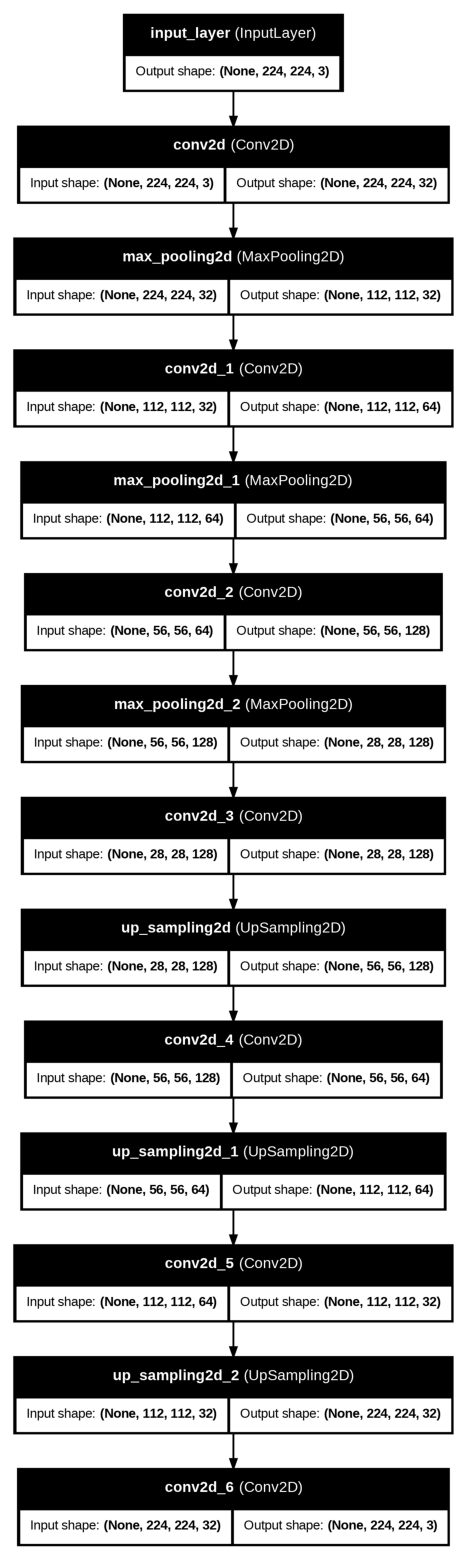

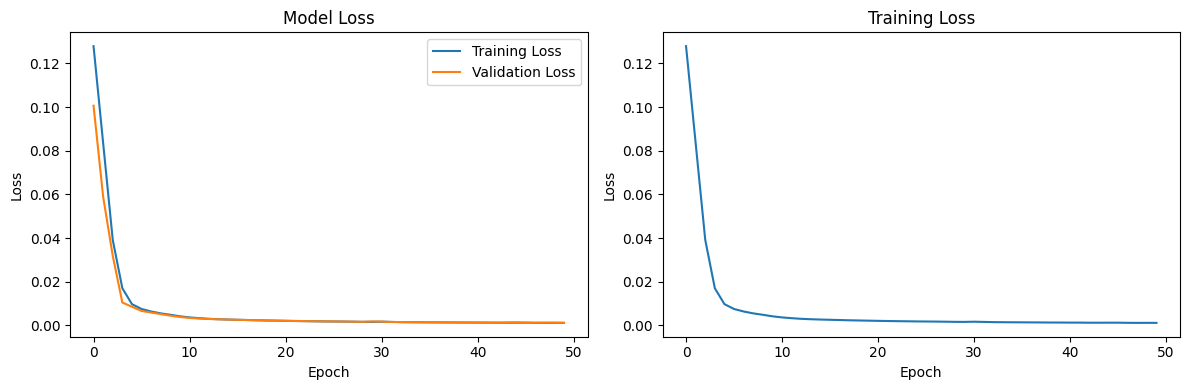

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

# Visualize the model architecture
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image
img = plt.imread('autoencoder_architecture.png')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off')
plt.show()

# Optionally, visualize the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

## 4. Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Compute reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=(1, 2, 3))

# Function to calculate accuracy for a given threshold
def calculate_accuracy(mse, y_true, threshold):
    y_pred = (mse > threshold).astype(int)
    return accuracy_score(y_true, y_pred)

# Range of percentiles to try
percentiles = range(1, 100)

# Calculate accuracy for each percentile
accuracies = []
for p in percentiles:
    threshold = np.percentile(mse, p)
    acc = calculate_accuracy(mse, y_test, threshold)
    accuracies.append(acc)

# Find the percentile with the highest accuracy
best_percentile = percentiles[np.argmax(accuracies)]
best_threshold = np.percentile(mse, best_percentile)
best_accuracy = max(accuracies)

print(f"Percentile: {best_percentile}")
print(f"Threshold: {best_threshold:.4f}")
print(f"Accuracy: {best_accuracy*100:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percentiles, accuracies)
plt.title('Accuracy vs Percentile Threshold')
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.axvline(x=best_percentile, color='r', linestyle='--', label=f'Best Percentile: {best_percentile}')
plt.legend()
plt.grid(True)
plt.show()

# Use the best threshold to make final predictions
y_pred_best = (mse > best_threshold).astype(int)

## 5. Visualize Results

In [ ]:
def plot_images(original, reconstructed, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title(titles[0])
    axes[1].imshow(reconstructed)
    axes[1].set_title(titles[1])
    plt.tight_layout()
    plt.show()

# Plot some example results
for i in range(5):
    original = X_test[i]
    reconstructed = reconstructions[i]
    anomaly = "Anomaly" if y_pred[i] == 1 else "Normal"
    plot_images(original, reconstructed, [f"Original ({anomaly})", "Reconstructed"])


## 6. Implement Continuous Learning and Adaptation

In [ ]:
def update_model(model, new_data, epochs=5):
    model.fit(new_data, new_data, epochs=epochs, batch_size=32, shuffle=True, verbose=0)
    return model

# Simulate continuous learning (in practice, this would be integrated with your data collection pipeline)
def continuous_learning(model, data_generator, update_frequency=1000):
    for i, new_batch in enumerate(data_generator):
        if i % update_frequency == 0:
            model = update_model(model, new_batch)
    return model

# Example usage (you'd need to implement a proper data generator for your production environment)
# continuous_learning(autoencoder, your_data_generator)

## 7. Implement Dynamic Tolerance Adjustment

In [ ]:
def adjust_tolerance(mse_values, percentile=95):
    return np.percentile(mse_values, percentile)

# Example usage (you'd call this periodically with recent MSE values)
# new_threshold = adjust_tolerance(recent_mse_values)

## 8. Real-time Feedback System

In [ ]:
def analyze_image(model, image, threshold):
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255.0
    reconstruction = model.predict(np.expand_dims(image, axis=0))[0]
    mse = np.mean(np.square(image - reconstruction))
    is_anomaly = mse > threshold
    return is_anomaly, mse

# Example usage in a production environment
# while True:
#     new_image = capture_new_image()  # Implement this function to capture images from your production line
#     is_anomaly, mse = analyze_image(autoencoder, new_image, threshold)
#     if is_anomaly:
#         alert_production_line(mse)  # Implement this function to send alerts or stop the production line

print("Carbon Brush Visual Anomaly Detection system is ready for deployment.")